loading the dataset 

In [2]:
from google.colab import files
uploaded = files.upload()


Saving claims.csv to claims.csv


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('claims_1.csv')

# adding claim id col
df.insert(0, "ClaimID", range(1, len(df) + 1))

df.head()

,ClaimID,ReportingDelay,AccidentHour,Age,WeeklyRate,Gender,MaritalStatus,HoursWorkedPerWeek,DependentChildren,DependentsOther,PartTimeFullTime,DaysWorkedPerWeek,DateOfAccident,ClaimDescription,ReportedDay,InitialCaseEstimate,Incurred
0,1,15,11,28,500.00,M,S,44.0,0,0,F,5,5/10/2005,STRUCK SCAFFOLDING STRAIN LOWER BACK,3Thurs,9500,151.254501
1,2,22,5,29,500.00,M,S,38.0,0,0,F,5,28/10/2003,STRUCK KNIFE LACERATED LEFT THUMB,2Wed,11500,442.125024
2,3,22,7,28,197.37,M,M,16.0,0,0,P,3,25/05/2004,SLIPPED AND HIT STRAINED LEFT SHOULDER INJURY ...,2Wed,8000,1494.490505
3,4,15,12,40,0.00,M,M,0.0,1,0,F,5,21/07/1994,HIT FALLING DOOR LACERATION LEFT SHOULDER INJU...,4Fri,500,138.900000
4,5,38,12,22,435.70,M,M,38.0,0,0,F,5,9/06/1992,STRUCK FALLING OBJECT LACERATION RIGHT RING FI...,4Fri,320,296.160000


loading the model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "tiiuae/falcon-7b-instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model in 8-bit (memory efficient) mode
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # fallback to float16 if Colab GPU doesn't support bf16
    device_map="auto"
)


c:\Users\Aeiman Imtiaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

testing the model tiiuae/falcon-7b-instruct



In [7]:
claim = "STRUCK SCAFFOLDING STRAIN LOWER BACK"

prompt = f"Convert the following keywords into a complete sentence:\n\nKeywords: {claim.lower().capitalize()}\nSentence:"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=50, do_sample=True, temperature=0.7)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Convert the following keywords into a complete sentence:

Keywords: Struck scaffolding strain lower back
Sentence: The worker's lower back was strained when scaffolding collapsed.


testing the model on dataset

In [10]:
# Create a copy of the first 10 rows to avoid modifying the whole DataFrame yet
subset_df = df.head(10).copy()

# Function to generate a full sentence from ClaimDescription
def generate_detailed_description(claim):
    prompt = (
        f"Convert the following injury keywords into a realistic claim statement. "
        f"The sentence should sound like something a person would say when reporting the incident.\n\n"
        f"Keywords: {claim.lower().capitalize()}\n"
        f"Statement:"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=50, do_sample=True, temperature=0.7)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_output.replace(prompt, "").strip()

# Apply to first 10 rows
subset_df["DetailedClaimDescription"] = subset_df["ClaimDescription"].apply(generate_detailed_description)

# Show result
subset_df[["ClaimDescription", "DetailedClaimDescription"]]


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


,ClaimDescription,DetailedClaimDescription
0,STRUCK SCAFFOLDING STRAIN LOWER BACK,I suffered a lower back strain from a falling ...
1,STRUCK KNIFE LACERATED LEFT THUMB,I suffered a laceration to my left thumb when ...
2,SLIPPED AND HIT STRAINED LEFT SHOULDER INJURY ...,I slipped and hit my left shoulder while using...
3,HIT FALLING DOOR LACERATION LEFT SHOULDER INJU...,"I suffered an injury, including a hit by a fal..."
4,STRUCK FALLING OBJECT LACERATION RIGHT RING FI...,I was injured when a falling object struck my ...
5,KNIFE SLIPPED CUT LEFT INDEX FINGER,I accidentally cut my left index finger with a...
6,SLIPPED ON STEEL BEAM LOWER BACK BRUISING KNEE...,"I slipped on a steel beam, resulting in lower ..."
7,LIFTING METAL SHEETS STRAIN LOWER BACK PAIN,I sustained a lower back injury while attempti...
8,LIFTING PATIENT BACK PAIN,I sustained back pain while lifting the patien...
9,SLIPPED OFF TRUCK BRUISED LOWER BACK RIGHT KNEE,"I slipped off a truck, resulting in bruises on..."


In [ ]:
import os
import pandas as pd

# Load the original dataset if not already loaded
# Uncomment and modify the file path if needed
# df = pd.read_csv("your_dataset.csv")

# Output file path
output_file = "claims_with_detailed_descriptions.csv"

# Set ClaimID to resume from
resume_claim_id = 3301
start_index = resume_claim_id - 1  # Convert ClaimID to 0-based index

# Load previous results if any
if os.path.exists(output_file):
    result_df = pd.read_csv(output_file)
    print(f"Existing output found. Will resume from ClaimID {resume_claim_id}.")
else:
    result_df = pd.DataFrame()
    print("No existing output file. Starting fresh.")

# Batch processing settings
batch_size = 150
total_rows = len(df)

# Loop through the dataset starting from the desired index
for start in range(start_index, total_rows, batch_size):
    end = min(start + batch_size, total_rows)
    print(f"Processing rows {start + 1} to {end}")

    batch = df.iloc[start:end].copy()
    batch["DetailedClaimDescription"] = batch["ClaimDescription"].apply(generate_detailed_description)

    # Append or write to CSV
    if os.path.exists(output_file):
        batch.to_csv(output_file, mode='a', header=False, index=False)
    else:
        batch.to_csv(output_file, index=False)

    print(f"Saved rows {start + 1} to {end} to file.")


applying function to dataset in batches

In [ ]:
import os
import pandas as pd

# Load original dataset again if needed
# df = pd.read_csv("your_dataset.csv")

# File to save results incrementally
output_file = "claims_final.csv"

# Determine starting point
if os.path.exists(output_file):
    result_df = pd.read_csv(output_file)
    start_id = result_df["ClaimID"].max() + 1
    print(f"Resuming from ClaimID {start_id}")
else:
    result_df = pd.DataFrame()
    start_id = 1
    print("Starting from scratch")

batch_size = 150
total_rows = len(df)

for start in range(start_id - 1, total_rows, batch_size):
    end = min(start + batch_size, total_rows)
    print(f"Processing rows {start + 1} to {end}")

    batch = df.iloc[start:end].copy()
    batch["DetailedClaimDescription"] = batch["ClaimDescription"].apply(generate_detailed_description)

    # Append to result file
    if os.path.exists(output_file):
        batch.to_csv(output_file, mode='a', header=False, index=False)
    else:
        batch.to_csv(output_file, index=False)

    print(f"Saved batch {start + 1}–{end} to file.")


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Starting from scratch
Processing rows 1 to 150


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1–150 to file.
Processing rows 151 to 300


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 151–300 to file.
Processing rows 301 to 450


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 301–450 to file.
Processing rows 451 to 600


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 451–600 to file.
Processing rows 601 to 750


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 601–750 to file.
Processing rows 751 to 900


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 751–900 to file.
Processing rows 901 to 1050


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 901–1050 to file.
Processing rows 1051 to 1200


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1051–1200 to file.
Processing rows 1201 to 1350


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1201–1350 to file.
Processing rows 1351 to 1500


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1351–1500 to file.
Processing rows 1501 to 1650


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1501–1650 to file.
Processing rows 1651 to 1800


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1651–1800 to file.
Processing rows 1801 to 1950


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1801–1950 to file.
Processing rows 1951 to 2100


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 1951–2100 to file.
Processing rows 2101 to 2250


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2101–2250 to file.
Processing rows 2251 to 2400


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2251–2400 to file.
Processing rows 2401 to 2550


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2401–2550 to file.
Processing rows 2551 to 2700


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2551–2700 to file.
Processing rows 2701 to 2850


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2701–2850 to file.
Processing rows 2851 to 3000


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 2851–3000 to file.
Processing rows 3001 to 3150


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 3001–3150 to file.
Processing rows 3151 to 3300


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 3151–3300 to file.
Processing rows 3301 to 3450


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

Saved batch 3301–3450 to file.
Processing rows 3451 to 3600


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

# Data Preprocessing and Feature Engineering

In [3]:

df = pd.read_csv('claims_2.csv')
# Save updated data if needed
df.head()



C:\Users\aimte\AppData\Local\Temp\ipykernel_21660\63076246.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('claims_2.csv')


,ClaimID,ReportingDelay,AccidentHour,Age,WeeklyRate,Gender,MaritalStatus,HoursWorkedPerWeek,DependentChildren,DependentsOther,PartTimeFullTime,DaysWorkedPerWeek,DateOfAccident,ClaimDescription,ReportedDay,InitialCaseEstimate,Incurred,DetailedClaimDescription
0,1,15,11.0,28.0,500.00,M,S,44.0,0.0,0.0,F,5.0,5/10/2005,STRUCK SCAFFOLDING STRAIN LOWER BACK,3Thurs,9500.0,151.254501,I suffered a lower back injury when a scaffold...
1,2,22,5.0,29.0,500.00,M,S,38.0,0.0,0.0,F,5.0,28/10/2003,STRUCK KNIFE LACERATED LEFT THUMB,2Wed,11500.0,442.125024,I suffered a laceration on my left thumb when ...
2,3,22,7.0,28.0,197.37,M,M,16.0,0.0,0.0,P,3.0,25/05/2004,SLIPPED AND HIT STRAINED LEFT SHOULDER INJURY ...,2Wed,8000.0,1494.490505,"I slipped and hit my left shoulder, resulting ..."
3,4,15,12.0,40.0,0.00,M,M,0.0,1.0,0.0,F,5.0,21/07/1994,HIT FALLING DOOR LACERATION LEFT SHOULDER INJU...,4Fri,500.0,138.900000,I sustained an injury when the door unexpected...
4,5,38,12.0,22.0,435.70,M,M,38.0,0.0,0.0,F,5.0,9/06/1992,STRUCK FALLING OBJECT LACERATION RIGHT RING FI...,4Fri,320.0,296.160000,I filed a claim for an injury sustained when I...


In [4]:
df.shape


(33776, 18)

removing duplicates

In [5]:
duplicates = df[df.duplicated()]
print(f"🔍 Number of duplicate rows: {len(duplicates)}")
print(duplicates.head())
df = df.drop_duplicates()


🔍 Number of duplicate rows: 11076
      ClaimID ReportingDelay  AccidentHour   Age  WeeklyRate Gender  \
21692    9606            101          17.0  30.0      666.71      M   
21693    9607             43           9.0  39.0      583.80      M   
21694    9608             37           7.0  21.0        0.00      M   
21695    9609             13          16.0  54.0      565.00      F   
21696    9610             30          15.0  29.0      500.00      M   

      MaritalStatus  HoursWorkedPerWeek  DependentChildren  DependentsOther  \
21692             U                38.0                0.0              0.0   
21693             M                40.0                0.0              0.0   
21694             S                 0.0                0.0              0.0   
21695             M                38.0                0.0              0.0   
21696             S                38.0                0.0              0.0   

      PartTimeFullTime  DaysWorkedPerWeek DateOfAccident  \
2169

In [6]:
# Check for exact duplicate claim descriptions
duplicate_descriptions = df[df['ClaimDescription'].duplicated(keep=False)]

# View duplicates grouped together
duplicate_groups = duplicate_descriptions.sort_values('ClaimDescription')

# Print count
print(f"Total duplicate claim descriptions: {duplicate_descriptions.shape[0]}")
# Find duplicates based on 'ClaimDescription' and 'Incurred'
duplicates = df[df.duplicated(subset=['ClaimDescription', 'Incurred'], keep=False)]

# Sort and view the duplicates
duplicates = duplicates.sort_values(by=['ClaimDescription', 'Incurred'])

# Print how many such duplicates exist
print(f"Total duplicates based on ClaimDescription and Incurred: {duplicates.shape[0]}")
# Drop duplicates based on just those two columns
df = df.drop_duplicates(subset=['ClaimDescription', 'Incurred'])




Total duplicate claim descriptions: 13839
Total duplicates based on ClaimDescription and Incurred: 2029


In [7]:
# Find all duplicate rows (every column matches)
duplicate_rows = df[df.duplicated(keep=False)]

# View them sorted for easier inspection
duplicate_rows = duplicate_rows.sort_values(by=list(df.columns))

# Print total count of duplicates
print(f"Total duplicate rows: {duplicate_rows.shape[0]}")


Total duplicate rows: 0


In [8]:
duplicate_indices = df[df.duplicated()].index
print("🔁 Duplicate row indices:", duplicate_indices.tolist())


🔁 Duplicate row indices: []


In [9]:
df.isnull().sum()

ClaimID                      0
ReportingDelay               1
AccidentHour                 1
Age                          1
WeeklyRate                   1
Gender                       1
MaritalStatus               23
HoursWorkedPerWeek           1
DependentChildren            1
DependentsOther              1
PartTimeFullTime             1
DaysWorkedPerWeek            1
DateOfAccident               1
ClaimDescription             1
ReportedDay                  1
InitialCaseEstimate          1
Incurred                     1
DetailedClaimDescription     1
dtype: int64

features coorelation

🔍 Correlation with Incurred:
Incurred               1.000000
InitialCaseEstimate    0.419226
WeeklyRate             0.134489
Age                    0.089215
HoursWorkedPerWeek     0.044742
DependentsOther        0.025558
DependentChildren      0.015964
DaysWorkedPerWeek     -0.012999
AccidentHour          -0.019066
Name: Incurred, dtype: float64


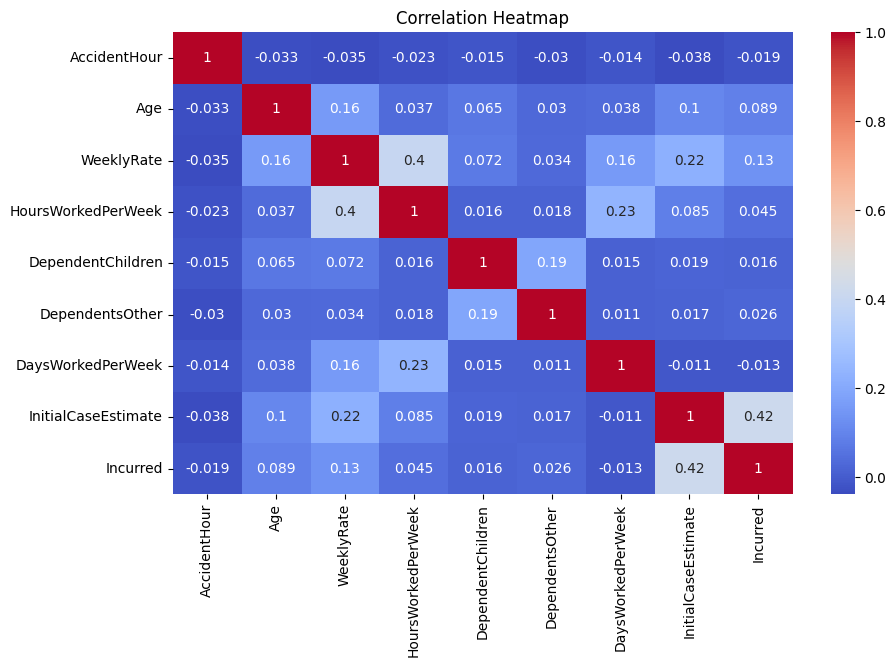

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = df.select_dtypes(include='number').dropna()

# Now compute correlation matrix
corr_matrix = numeric_cols.corr()

# Show correlation with 'Incurred'
if 'Incurred' in corr_matrix.columns:
    corr_with_incurred = corr_matrix['Incurred'].sort_values(ascending=False)
    print("🔍 Correlation with Incurred:")
    print(corr_with_incurred)
else:
    print("❗ 'Incurred' not found in correlation matrix.")


# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


assigning label

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr

# Step 0: Preprocessing
df['EstimateGap'] = df['Incurred'] - df['InitialCaseEstimate']
df['DetailedClaimDescription'] = df['DetailedClaimDescription'].fillna('')
df['ReportingDelay'] = df['ReportingDelay'].fillna(0)

# Step 1: TF-IDF keyword correlation with Incurred
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['DetailedClaimDescription'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Compute Spearman correlations between word usage and Incurred
word_correlations = {
    word: spearmanr(tfidf_df[word], df['Incurred'])[0]
    for word in tfidf_df.columns
}

# Identify top and bottom 20 keywords
word_corr_series = pd.Series(word_correlations).sort_values()
low_risk_words = set(word_corr_series.head(20).index)
high_risk_words = set(word_corr_series.tail(20).index)

# Match high/low-risk words in InputText
def match_keywords(text, keywords):
    text = text.lower()
    return any(word in text for word in keywords)

df['HasHighRiskWord'] = df['DetailedClaimDescription'].apply(lambda x: match_keywords(x, high_risk_words))
df['HasLowRiskWord'] = df['DetailedClaimDescription'].apply(lambda x: match_keywords(x, low_risk_words))

# Step 2: Quantile binning
df['IncurredQuantile'] = pd.qcut(df['Incurred'], q=3, labels=['LowCost', 'MediumCost', 'HighCost'])

# Step 3: Assign severity using only IncurredQuantile
def determine_severity(row):
    if row['IncurredQuantile'] == 'HighCost':
        return 'High'
    elif row['IncurredQuantile'] == 'LowCost':
        return 'Low'
    else:  # MediumCost
        return 'Medium'

df['SeverityLabel'] = df.apply(determine_severity, axis=1)
# Count the number of claims in each severity category
severity_counts = df['SeverityLabel'].value_counts()
print(severity_counts)



SeverityLabel
Medium    7229
Low       7228
High      7228
Name: count, dtype: int64


dropping extra features

In [12]:
columns_to_drop = ['EstimateGap', 'HasHighRiskWord', 'HasLowRiskWord', 'IncurredQuantile']
df = df.drop(columns=columns_to_drop)


generating text input from the dataset

In [13]:
# === Mapping dictionaries ===
gender_map = {'M': 'male', 'F': 'female'}
marital_map = {'S': 'single', 'M': 'married', 'U': 'unmarried'}
work_type_map = {'F': 'full-time', 'P': 'part-time'}

# === Templates for each column (diverse paraphrasing) ===
templates = {
    "Age": [
        "I am {Age} years old.",
        "I'm currently {Age}.",
        "My age is {Age}.",
        "At present, I am {Age} years of age.",
        "I’ve reached the age of {Age}.",
        "I’m aged {Age}.",
        "Currently, I am {Age}.",
        "I was born {Age} years ago.",
        "I fall in the {Age}-year age group.",
        "I’ve lived for {Age} years now."
    ],
    "Gender": [
        "I am a {Gender}.",
        "I identify as {Gender}.",
        "Gender: {Gender}.",
        "My gender is {Gender}.",
        "As a {Gender}, I face certain challenges.",
        "Being {Gender} has influenced my experience.",
        "I live my life as a {Gender}.",
        "I was registered as {Gender} at birth.",
        "Socially, I identify as {Gender}.",
        "Biologically, I am {Gender}."
    ],
    "MaritalStatus": [
        "I am {MaritalStatus}.",
        "I'm currently {MaritalStatus}.",
        "Marital status: {MaritalStatus}.",
        "I live as a {MaritalStatus} person.",
        "I consider myself to be {MaritalStatus}.",
        "Currently, I’m {MaritalStatus} in terms of relationship status.",
        "In terms of my personal life, I'm {MaritalStatus}.",
        "I have a {MaritalStatus} lifestyle.",
        "Relationship-wise, I’m {MaritalStatus}.",
        "I’m leading a {MaritalStatus} life."
    ],
    "DateOfAccident": [
        "I had an accident on {DateOfAccident}.",
        "The accident occurred on {DateOfAccident}.",
        "It happened on {DateOfAccident}.",
        "The incident took place on {DateOfAccident}.",
        "The mishap happened on {DateOfAccident}.",
        "That unfortunate day was {DateOfAccident}.",
        "I remember it clearly—it was {DateOfAccident} when the accident occurred.",
        "The event happened on {DateOfAccident}.",
        "I met with the accident on {DateOfAccident}.",
        "The injury happened on {DateOfAccident}."
    ],
    "ReportedDay": [
        "It was reported on {ReportedDay}.",
        "I made the report on {ReportedDay}.",
        "The report was filed on {ReportedDay}.",
        "Reported day: {ReportedDay}.",
        "I officially reported it on {ReportedDay}.",
        "The day I submitted the report was {ReportedDay}.",
        "I remember reporting it on {ReportedDay}.",
        "I contacted the authorities on {ReportedDay}.",
        "I filed the claim on {ReportedDay}.",
        "The issue was recorded on {ReportedDay}."
    ],
    "PartTimeFullTime": [
        "I work {PartTimeFullTime}.",
        "My job is {PartTimeFullTime}.",
        "Employment type: {PartTimeFullTime}.",
        "I am employed {PartTimeFullTime}.",
        "I currently have a {PartTimeFullTime} job.",
        "My role requires me to work in a {PartTimeFullTime} capacity.",
        "I’m engaged in {PartTimeFullTime} employment.",
        "I am a {PartTimeFullTime} employee.",
        "I work on a {PartTimeFullTime} basis.",
        "My job type is {PartTimeFullTime}."
    ],
    "HoursWorkedPerWeek": [
        "I usually work {HoursWorkedPerWeek} hours per week.",
        "My weekly working hours are {HoursWorkedPerWeek}.",
        "I work {HoursWorkedPerWeek} hours each week.",
        "Average weekly hours: {HoursWorkedPerWeek}.",
        "In a typical week, I put in about {HoursWorkedPerWeek} hours.",
        "I dedicate {HoursWorkedPerWeek} hours weekly to my job.",
        "Every week, I spend around {HoursWorkedPerWeek} hours working.",
        "My workload per week totals {HoursWorkedPerWeek} hours.",
        "On average, I log {HoursWorkedPerWeek} work hours weekly.",
        "I’m scheduled for {HoursWorkedPerWeek} hours every week."
    ],
    "DependentChildren": [
        "I have {DependentChildren} dependent children.",
        "Number of dependent children: {DependentChildren}.",
        "There are {DependentChildren} children depending on me.",
        "Dependents (children): {DependentChildren}.",
        "I take care of {DependentChildren} kids.",
        "I’m responsible for {DependentChildren} dependent children.",
        "My household includes {DependentChildren} dependent children.",
        "I support {DependentChildren} children financially.",
        "I raise {DependentChildren} children.",
        "I provide for {DependentChildren} kids."
    ],
    "DependentsOther": [
        "I support {DependentsOther} other dependents.",
        "Dependents (others): {DependentsOther}.",
        "There are {DependentsOther} other people who depend on me.",
        "I look after {DependentsOther} non-child dependents.",
        "I financially support {DependentsOther} other individuals.",
        "Aside from children, I care for {DependentsOther} others.",
        "I have {DependentsOther} additional dependents under my care.",
        "I’m responsible for {DependentsOther} non-minor dependents.",
        "There are {DependentsOther} adults I help support.",
        "I assist {DependentsOther} others with living expenses."
    ],
    "WeeklyRate": [
        "My weekly rate is {WeeklyRate}.",
        "I earn {WeeklyRate} per week.",
        "Weekly wage: {WeeklyRate}.",
        "Each week, I get paid {WeeklyRate}.",
        "My income per week amounts to {WeeklyRate}.",
        "The amount I make weekly is {WeeklyRate}.",
        "I receive {WeeklyRate} weekly as part of my job.",
        "My weekly earnings total {WeeklyRate}.",
        "I get compensated {WeeklyRate} each week.",
        "The company pays me {WeeklyRate} weekly."
    ]
}


In [16]:
import random
def generate_input_text(row):
    gender = gender_map.get(row["Gender"], "unknown")
    marital = marital_map.get(row["MaritalStatus"], "unknown")
    work_type = work_type_map.get(row["PartTimeFullTime"], "unknown")

    # Handle NaNs gracefully
    values = {
        "Age": int(row["Age"]) if pd.notnull(row["Age"]) else "unknown",
        "Gender": gender,
        "MaritalStatus": marital,
        "DateOfAccident": row["DateOfAccident"] if pd.notnull(row["DateOfAccident"]) else "unknown",
        "ReportedDay": row["ReportedDay"] if pd.notnull(row["ReportedDay"]) else "unknown",
        "PartTimeFullTime": work_type,
        "HoursWorkedPerWeek": int(row["HoursWorkedPerWeek"]) if pd.notnull(row["HoursWorkedPerWeek"]) else "unknown",
        "DependentChildren": int(row["DependentChildren"]) if pd.notnull(row["DependentChildren"]) else "unknown",
        "DependentsOther": int(row["DependentsOther"]) if pd.notnull(row["DependentsOther"]) else "unknown",
        "WeeklyRate": int(row["WeeklyRate"]) if pd.notnull(row["WeeklyRate"]) and row["WeeklyRate"] > 0 else "not specified"
    }

    parts = []
    for col, templates_list in templates.items():
        if col in values and values[col] != "unknown":
            template = random.choice(templates_list)
            parts.append(template.format(**values))
    
    return " ".join(parts)


In [17]:
# Apply the function to the full DataFrame
df["InputText"] = df.apply(generate_input_text, axis=1)


modifying input texts , including text related to severity label

In [18]:
severity_templates = {
    "Low": [
        "It was a minor incident and I was back to work shortly.",
        "No major injuries were sustained, and I resumed duties soon.",
        "The injury wasn’t too serious, and I recovered quickly.",
        "I didn’t need much medical help and returned to work fast.",
        "I managed with basic care and had minimal downtime.",
        "The discomfort was manageable, and I stayed productive.",
        "Luckily, it wasn't severe and didn’t affect my work much.",
        "Only light first aid was needed, and I was fine afterward.",
        "There was no lasting impact, and I got better quickly.",
        "I was able to handle the injury with ease and return to work."
    ],
    "Medium": [
        "The injury required some medical attention and time off.",
        "I had to rest for a few days and get treated for the injury.",
        "It wasn’t critical, but it did affect my work temporarily.",
        "There was moderate pain and disruption to my routine.",
        "I missed a few shifts and received treatment.",
        "I had to take a break from work to recover properly.",
        "The incident led to a brief period of downtime.",
        "My workflow was impacted, but I managed to recover soon.",
        "I had to visit a doctor and follow up with rest.",
        "It was concerning enough to pause work temporarily."
    ],
    "High": [
        "The injury was severe and required immediate medical care.",
        "I was hospitalized and needed significant recovery time.",
        "It greatly impacted my ability to work and daily life.",
        "There was substantial pain and long-term treatment involved.",
        "I had to stop working for an extended period.",
        "The situation was critical and required surgery.",
        "Rehabilitation and time away from work were necessary.",
        "I experienced long-term discomfort from the injury.",
        "The accident disrupted my life and career significantly.",
        "It was a serious incident with lasting consequences."
    ]
}


In [20]:
import random

def add_severity_phrase(row):
    text = row['InputText']
    severity_label = row['SeverityLabel']
    phrase = random.choice(severity_templates[severity_label])
    return text.strip() + " " + phrase

# Apply the function row-wise
df["InputText"] = df.apply(add_severity_phrase, axis=1)

# Save the updated DataFrame
df.to_csv("claims_final.csv", index=False)

print("✅ InputText column updated and saved to claims_final.csv")


✅ InputText column updated and saved to claims_final.csv
